In [123]:
from torchvision.models import resnet18
from torchvision.models import resnet50
from torchvision.models import resnet101
from torch import nn, optim
import pandas as pd
import numpy as np
import cv2
import torch
import random
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

In [22]:
def data_loading(img_df,root_dir_img,root_dir_label,k_shot=7,num_classes=9):
    # load the images and labels and create training set
    imgs_dir=[[]]*num_classes
    masks_dir=[[]]*num_classes
    labels=[[]]*num_classes
    imgs_train=[[]]*num_classes
    labels_train=[[]]*num_classes
    masks_train=[[]]*num_classes
    train_ind=[[]]*num_classes
    query_ind=[[]]*num_classes
    np.random.seed(0)
    ttl_samples=0
    for i in range(1,10):
        class_name=class_names[i-1]
        img_id=list(img_df[img_df['majority_class_label']==i]['basename'])
        imgs_dir[i-1]=[str(Path(root_dir_img) / img)+'.jpg' for img in img_id]
        masks_dir[i-1]=[str(Path(root_dir_label)/class_name/img)+'.png' for img in img_id]
        labels[i-1]=list(img_df[img_df['majority_class_label']==i]['majority_class_label'])
        num_samples=len(imgs_dir[i-1])
        ttl_samples+=num_samples
        rand_img=list(np.random.randint(num_samples,size=k_shot))
        train_ind[i-1]=rand_img
        query_ind[i-1]=[i for i in list(np.arange(num_samples)) if i not in rand_img ]
        imgs_train[i-1]=[imgs_dir[i-1][j] for j in rand_img]
        labels_train[i-1]=[labels[i-1][j] for j in rand_img]
        masks_train[i-1]=[masks_dir[i-1][j] for j in rand_img]
    
    return (imgs_dir,labels),(imgs_train,labels_train),(query_ind)

In [23]:
def support_set(imgs_train,labels_train,k_shot=7,num_classes=9,inchannels=3,size=(512,512)):
    (h,w)=size
    val_stacked_imgs=np.zeros((k_shot*num_classes,inchannels,h,w))
    val_stacked_labels=np.zeros((k_shot*num_classes,1))
    ind=0
    for i in range(len(imgs_train)):
        num_samples=len(imgs_train[i])
        for j in range(num_samples):
            img_dir=imgs_train[i][j]
            img_label=labels_train[i][j]
            rgb = cv2.imread(img_dir, cv2.IMREAD_COLOR)
            rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
            val_stacked_imgs[ind]=rgb.transpose(2,0,1)
            val_stacked_labels[ind]=img_label
            ind+=1
    support_img=torch.from_numpy(val_stacked_imgs)
    support_label=torch.from_numpy(val_stacked_labels)
    
    return support_img,support_label

In [17]:
def query_set(imgs_dir,labels,query_ind,num_query=5,num_classes=9,inchannels=3,size=(512,512)):
    np.random.seed(1)
    (h,w)=size
    val_stacked_imgs=np.zeros((num_query*num_classes,inchannels,h,w))
    val_stacked_labels=np.zeros((num_query*num_classes,1))
    ind=0
    for i in range(num_classes):
        num_samples=len(query_ind[i])
        rand_ind=np.random.choice(query_ind[i],size=num_query,replace=False)
        for j in rand_ind :
            img_dir=imgs_dir[i][j]
            img_label=labels[i][j]
            rgb = cv2.imread(str(img_dir), cv2.IMREAD_COLOR)
            rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
            val_stacked_imgs[ind]=rgb.transpose(2,0,1)
            val_stacked_labels[ind]=img_label
            ind+=1 
    query_img=torch.from_numpy(val_stacked_imgs)
    query_label=torch.from_numpy(val_stacked_labels)
    
    return query_img,query_label

In [42]:
class DistanceNetworks(nn.Module):
    def __init__(self, backbone: nn.Module, dist_type='euclidean'):
        super(DistanceNetworks, self).__init__()
        self.backbone = backbone
        self.dist=dist_type

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        
        # add 1 dimension if only 1 query sample
        if len(query_images.shape)==3:
            query_images=query_images[None,:,:,:]
        z_query = self.backbone.forward(query_images) 
        if len(query_images.shape)==3:
            z_query=z_query[None,:,:]

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat([z_support[torch.nonzero(support_labels == label)].mean(0)for label in range(n_way)])
        
        #if self.dist=='linear_training': #try out that next time
            #return z_proto,z_query
        
        if self.dist=='euclidean':
            dists = torch.cdist(z_query, z_proto)
            scores=-dists
            
        else:
            dists=torch.zeros(query_images.shape[0],n_way)
            cos = nn.CosineSimilarity(dim=1, eps=1e-6)
            for i in range(query_images.shape[0]):
                for j in range(z_proto.shape[0]):
                    z_proto_i=z_proto[j]
                    dists[i][j]= cos(z_proto_i, z_query)
            scores = dists

        return scores

In [60]:
def evaluation (pretrain_model,proto_model,support_img,support_label,query,query_label,dist_type='cos_sim'):
    convolutional_network = pretrain_model(pretrained=True)
    convolutional_network.fc = nn.Flatten()
    model=proto_model(convolutional_network, dist_type=dist_type)
    model.eval()
    scores = model(support_img,support_label,query).detach()
    _, predicted_label = torch.max(scores.data, 1)
    
    return predicted_label

In [61]:
def trials (proto_model,support_img,support_label,query_img,query_label,pretrain_models_list,dist_type_list):
    support_img=support_img.to(torch.float32)
    support_lab= (support_label-1).view(-1)
    query_img=query_img.to(torch.float32)
    query_lab=(query_label-1).view(-1)
    pred_labels=np.zeros((len(pretrain_models_list),query_lab.shape[0],len(dist_type_list)))
    for i in range(len(pretrain_models_list)):
        model=pretrain_models_list[i]
        for j in range(len(dist_type_list)):
            dist_eval=dist_type_list[j]
            for k in range(query_lab.shape[0]):
                query=query_img[k]
                label=query_lab[k]
                output=evaluation(pretrain_model=model,proto_model=proto_model,support_img=support_img,support_label=support_lab,query=query,query_label=label,dist_type=dist_eval)
                pred_labels[i][k][j]=output
    return pred_labels     

In [ ]:
img_df=pd.read_csv('.../2021_val.csv')
img_df=img_df.loc[:,('basename','origin_set','majority_class_label')]
class_names=['double_plant','drydown','endrow','nutrient_deficiency','planter_skip','water','waterway','weed_cluster','storm_damage']
root_dir_img='.../2021/val/images/rgb'
root_dir_label='.../2021/val/labels'
k_shot=5 # number of support samples per class
num_query=5 # number of query samples per class
num_classes=9 # number of ttl classes
pretrain_models_list=[resnet18,resnet50,resnet101]
#pretrain_models_list=[resnet18]
dist_type_list=['cos_sim','euclidean']
#dist_type_list=['cos_sim']

In [65]:
output=data_loading(img_df,root_dir_img,root_dir_label,k_shot=k_shot)
(imgs_dir,labels),(imgs_train,labels_train),(query_ind)=output
support_img,support_label=support_set(imgs_train,labels_train)
query_img,query_label=query_set(imgs_dir,labels,query_ind,num_query=num_query)
support_lab= (support_label-1).view(-1)
query_lab=(query_label-1).view(-1)
pred_labels = trials(DistanceNetworks,support_img,support_lab,query_img,query_lab,pretrain_models_list,dist_type_list)

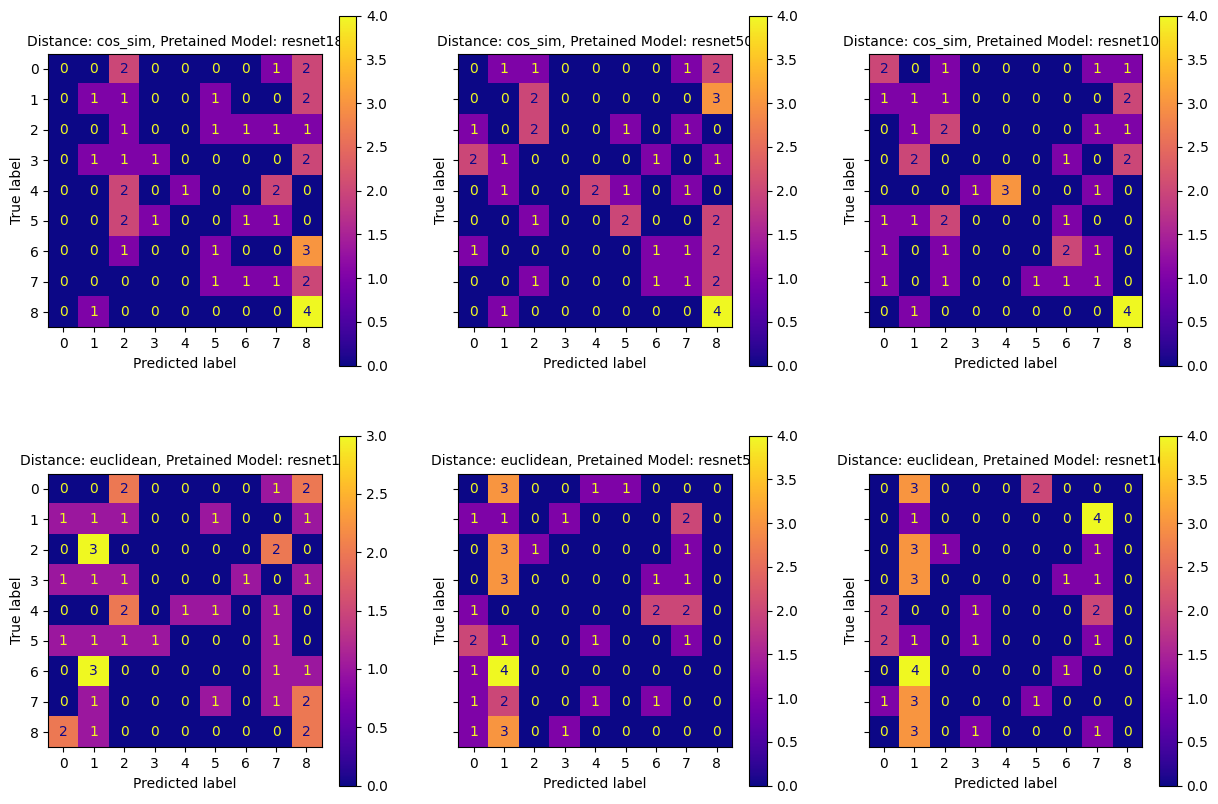

In [167]:
pretrain_models_name=['resnet18','resnet50','resnet101']
dist_type_list=['cos_sim','euclidean']
f, ax = plt.subplots(2, 3, figsize=(15, 10), sharey='row')
for row in range(2):
    dist=row
    dist_name=dist_type_list[dist]
    for col in range(3):
        model=col
        model_name=pretrain_models_name[col]
        y_test=query_lab
        y_pred=pred_labels[col][:,row]
        ax[row,col].set_title("Distance: %s, Pretained Model: %s"%(dist_name,model_name), size=10)
        ConfusionMatrixDisplay.from_predictions(y_test,y_pred, labels=np.arange(len(class_names)),cmap="plasma", ax=ax[row, col])